# Imports e Setup $\sqrt{}$
$\alpha := 5 \%$ !!!

In [82]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import random as rd
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
sns.set_theme(context="notebook")
from tqdm import tqdm

# scipy.fft é melhor !
# https://stackoverflow.com/questions/6363154/what-is-the-difference-between-numpy-fft-and-scipy-fftpack
from scipy.fft import fft
from scipy.fftpack.helper import fftfreq
# from numpy.fft import fft,fftfreq

from scipy.stats import f as FDIST
from scipy.stats.distributions import chi2

In [83]:
# Calcula valor crítico em ORD qualquer, calculando quantil 95%
def vc_pratico(ORD, alpha = 0.05):
    return np.quantile(a= ORD, q = 1-alpha)

# SFT: Spectral F-Test $\sqrt{}$

## Definição e Funções

<img src = "sft.png"/>

In [84]:
def vc_SFT(L, alpha = 0.05, VERBOSE = 0):
    # valor crítico teórico, dado tomando inversa da distribuição acumulada F
    # (Fisher-Snedecor)
    # com significancia 1-alpha (95% se não for alterada)
    vc = FDIST.ppf(1-alpha, 2,2*L) 
    
    if VERBOSE==1:
        print('Significância desejada: ',alpha*100,'\b%')
    if VERBOSE==2:
        print('Significância desejada: ',alpha*100,'\b%')
        print('Valor crítico SFT: ',vc)

    return vc
        #fce999 TODO: perguntar por que 2 e 2*L!

def ord_SFT(sinal, L, BIN):
    # L: tamanho das laterais
    SINAL = fft(sinal)

    central = round(BIN) # certifica inteiro (não float)
    lateralMenor = round(central-L/2)
    lateralMaior = round(central+L/2)+1       

    DEN =np.abs(SINAL[central])**2
    SINAL_lateral = np.array(list(SINAL[lateralMenor:central])+list(SINAL[central+1:lateralMaior])) 
    NUM = (1/L)*np.sum(np.abs(SINAL_lateral)**2)
    SFT = DEN/NUM
    
    return [SINAL,SFT]

## Single-shot

In [85]:
from tqdm import tqdm 

nSim = 1e4
L = 6
BIN = 30

vc = vc_SFT(L=L,alpha=0.02)
nd = 0
hist = []

for i in tqdm(range(1,round(nSim+1))):
    x = np.zeros((round(nSim),))

    x = rd.randn(round(nSim))
    [X, ORD]= ord_SFT(sinal = x, L = L, BIN = BIN)
    if ORD>vc: nd+=1


print('Taxa de FP: '+str(nd/nSim *100))

100%|██████████| 10000/10000 [00:04<00:00, 2289.88it/s]

Taxa de FP: 1.92


# CSM: Component Synchrony Measure $\sqrt{}$

## Definição e Funções: 

<img src = "csm.png"/>

In [86]:
def vc_CSM(M, alpha = 0.05, VERBOSE=0):
    vc = chi2.ppf(1-alpha,2)/(2*M)
    
    if VERBOSE==1:
        print('Significância desejada: ',alpha*100,'\b%')
    if VERBOSE==2:
        print('Significância desejada: ',alpha*100,'\b%')
        print('Valor crítico CSM: ',vc)

    return vc


def ord_CSM(sinal, tamanhoJanela, M):
    if len(sinal)-tamanhoJanela*M>=0:
        
        sinal = np.reshape(sinal[0:tamanhoJanela*M], (tamanhoJanela,M))


        FFT_SINAL = fft(sinal)

        CSM = (np.sum(np.cos(np.angle(FFT_SINAL)),axis=1)/M)**2 + (np.sum(np.sin(np.angle(FFT_SINAL)),axis=1)/M)**2

        return [FFT_SINAL,CSM]
    else:
        print('Erro no número de janelas', round(tamanhoJanela),'(ou amostras, M =', M,'\b) escolhido.')
        print('Tamanho do Sinal menos M*tamanhoJanela:', len(sinal)-M*tamanhoJanela)
        print('(Retorna 0)')
        return 0 

## Single-shot

In [87]:
from tqdm import tqdm 

nSim = round(1e4)

fs = 100 # frequencia de amostragem
tj = 100 # tamanho da janela (1 seg/janela, pra facilitar)
M = 100 # teste em 100 segundos
vc = vc_CSM(M)

N = round(M*tj)
BIN = 42
nd = 0
ndp = 0
hist = []


for i in tqdm(range(1,nSim+1)):
    x = np.zeros((N,))

    x = rd.randn(N)
    [X, ORD]= ord_CSM(sinal=x, tamanhoJanela=tj, M=M)
    # print(ORD)

    if ORD[BIN]>vc: nd+=1

    vcp = vc_pratico(ORD)
    if ORD[BIN]>vcp: ndp+=1

    hist.append(ORD)

vcp = vc_pratico(hist)

print('Taxa de FP: '+str(nd/nSim *100))


100%|██████████| 10000/10000 [00:14<00:00, 679.05it/s]

Taxa de FP: 7.91


### Gráfico de comparação entre VC Teórico e Prático

> ~ COMPARAÇÕES ~

In [88]:
print('\n ~ COMPARAÇÕES ~')
print('Valor critico pratico: ',vcp)
print('Valor critico teorico: ',vc)
print('Erro relativo:' , round((vcp-vc)/vc*100,ndigits=2),'\b%')

print('Taxa de FP (vc_teorico): '+str(round(nd/nSim *100,ndigits=2)),'\b%')
print('Taxa de FP (vc_pratico): '+str(round(ndp/nSim *100,ndigits=2)),'\b%')
# sns.lineplot(y= hist,x=range(1,nSim+1));


 ~ COMPARAÇÕES ~
Valor critico pratico:  0.038253162846292904
Valor critico teorico:  0.029957322735539894
Erro relativo: 27.69%
Taxa de FP (vc_teorico): 7.91%
Taxa de FP (vc_pratico): 4.67%


## Sequencial:

In [89]:
# Dois testes:
from tqdm import tqdm 

nSim = 1e4

fs = 126 
tj = 126 # cada janela um segundo 
alfa = 0.05

M1test = 31 # teste em 30 segundos 
M2test = 60 # teste em 60 segundos

vc1 = vc_CSM(M1test)
vc2 = vc_CSM(M2test)

Mmax = M2test; 
N = Mmax *tj;
BIN = 30
nd = 0
hist = []


for i in tqdm(range(1,round(nSim+1))):
    x = np.zeros((Mmax*tj,))

    x[0:M1test*tj] = rd.randn(M1test*tj)
    [X, ORD]= ord_CSM(sinal=x, tamanhoJanela=tj, M=M1test)

    if ORD[BIN]>vc1: nd+=1
    else:
        x[M1test*tj:tj*M2test+1] = rd.randn((M2test-M1test)*tj)
        [X, ORD]= ord_CSM(sinal=x, tamanhoJanela=tj, M=M2test)
        if ORD[BIN]>vc2: nd+=1


print('Taxa de FP: '+str(round(nd/nSim *100,ndigits=2)),'\b%')

100%|██████████| 10000/10000 [00:14<00:00, 695.71it/s]

Taxa de FP: 15.66%


# MSC: Magnitude-Squared Coherence $\sqrt{}$

## Definição e Funções

<img src = "../res/msc.png"/>

In [90]:
def vc_MSC(M, alpha = 0.05, VERBOSE = 0):
    vc = 1-alpha**(1/(M-1))
    if VERBOSE==1:
        print('Significância desejada: ',alpha*100,'\b%')
    if VERBOSE==2:
        print('Significância desejada: ',alpha*100,'\b%')
        print('Valor crítico MSC: ',vc)
    return vc # valor crítico

def ord_MSC(sinal, tamanhoJanela, M):
    sinal = np.reshape(sinal[0:tamanhoJanela*M], (tamanhoJanela,M))

    SINAL = fft(sinal)
    
    MSC = (np.abs(np.sum(SINAL,axis=1))**2) / (M*np.sum(np.abs(SINAL)**2,axis=1))

    return [SINAL,MSC]

## Single-shot:

In [91]:
from tqdm import tqdm 

nSim = round(1e4)
N = 1e4 # pontos
x = np.zeros((N,))

nd = 0
ndp = 0
hist = []


for i in tqdm(range(1,nSim+1)):
    x = rd.randn(N)
    
    [_, ORD]= ord_SFT(sinal=x, tamanhoJanela=tj, M=M)


# Só por comparação e discussão:
print('\n ~ COMPARAÇÕES ~')
print('Valor critico pratico: ',vc_pratico(ORD))

print('Taxa de FP (vc_t): '+str(round(nd/nSim *100,ndigits=2)),'\b%')
print('Taxa de FP (vc_p): '+str(round(ndp/nSim *100,ndigits=2)),'\b%')

100%|██████████| 10000/10000 [00:17<00:00, 558.19it/s]


 ~ COMPARAÇÕES ~
Valor critico pratico:  0.01812842533777315
Taxa de FP (vc_t): 8.64%
Taxa de FP (vc_p): 5.02%


## Sequencial:

In [92]:
# Apenas 2 testes (exempo):
from tqdm import tqdm 

nSim = 1e4

fs = 126 
tj = 126 # cada janela um segundo 
alfa = 0.05

M1test = 31 # teste em 30 segundos 
M2test = 60 # teste em 60 segundos

vc1 = vc_MSC(M1test)
vc2 = vc_MSC(M2test)

Mmax = M2test; 
N = Mmax *tj
BIN = 30
nd = 0
hist = []


for i in tqdm(range(1,round(nSim+1))):
    x = np.zeros((Mmax*tj,))

    x[0:M1test*tj] = rd.randn(M1test*tj)
    [X, ORD]= ord_MSC(sinal=x, tamanhoJanela=tj, M=M1test)

    if ORD[BIN]>vc1: nd+=1
    else:
        x[M1test*tj:tj*M2test+1] = rd.randn((M2test-M1test)*tj)
        [X, ORD]= ord_MSC(sinal=x, tamanhoJanela=tj, M=M2test)
        if ORD[BIN]>vc2: nd+=1


print('Taxa de FP: '+str(nd/nSim *100),'\b%')

100%|██████████| 10000/10000 [00:05<00:00, 1820.82it/s]

Taxa de FP: 16.38%


In [93]:
# Sequencial generalizado:
from tqdm import tqdm 

nSim = round(1e4)

fs = 100 
tj = 100 # cada janela um segundo 
alfa = 0.05

M = 30 # teste em 30 segundos
Mstep = 10

vc = vc_MSC(M)

Mmax = 90; 
N = round(Mmax*tj)
BIN = 30
nd = 0
hist = []


for i in tqdm(range(1,nSim+1)):
    x = np.zeros((N,))
    x = rd.randn(N)

    for M_atual in range(M, Mmax, Mstep):
        [X, ORD]= ord_MSC(sinal=x, tamanhoJanela=tj, M=M_atual)

        if ORD[BIN]>vc: nd+=1

print('Taxa de FP: '+str(nd/nSim *100),'\b%')

100%|██████████| 10000/10000 [00:10<00:00, 911.66it/s]

Taxa de FP: 18.8%


# Controle de significância (MSC) $\sqrt{}$

## Definindo:

In [94]:
# Usando sequencial generalizado, queremos FP= 5% no teste GERAL! Qual deve ser FPi (cada iteração)?

def corrige_alfaMSC(
    tj = 100, # cada janela um segundo 
    Mmin = 10,
    Mstep = 10,
    Mmax = 60,
    BIN = 7,
    alphaD = 5/100,  #fff significancia a atingir
    alphaInicial = -1,
    tx_apr = 0.02,    # taxa de aprendizado
    nSim = 1e3, 
    itMAX = 300,
    VERBOSE = 1):

    print('\nCalculando alpha corrigido para alphaD =', alphaD)

    N = round(Mmax*tj)  # tamanho máximo do sinal
    nSim = round(nSim)  # numero de simulações
    if alphaInicial<0: alphas = [alphaD/(Mmax/Mstep)] # primeiro "chute" = alpha Desejado
    else: alphas = [alphaInicial]
    alphaR = 1   # significancia REAL
    it = 1  # iteração atual

    while alphaR > alphaD and it <= itMAX:
        if it>1:
            # Se J = mse = e^2 (univariado), então:
            grad = 2*alphaR - alphaD
            alphas.append(alphas[-1] -tx_apr*(grad))

        descricao = 'Iteração #'+str(it); it+=1; nd = 0; 
        
        if VERBOSE>=2:
            for _ in tqdm(range(1,nSim+1), leave=(VERBOSE>1), desc=descricao):
                x = rd.randn(N) # gera o "sinal" completo
                for M in range(Mmin, Mmax+Mstep,Mstep):
                    vc = vc_MSC(M,alpha=alphas[-1])            
                    [_, ORD]= ord_MSC(sinal=x, tamanhoJanela=tj, M=M)
                    if ORD[BIN]>vc: nd+=1

        if VERBOSE==1:
            for _ in tqdm(range(1,nSim+1), leave=False):
                x = rd.randn(N) # gera o "sinal" completo
                for M in range(Mmin, Mmax+Mstep,Mstep):
                    vc = vc_MSC(M,alpha=alphas[-1])            
                    [_, ORD]= ord_MSC(sinal=x, tamanhoJanela=tj, M=M)
                    if ORD[BIN]>vc: nd+=1

        else:
            for _ in range(1,nSim+1):
                x = rd.randn(N) # gera o "sinal" completo
                for M in range(Mmin, Mmax+Mstep,Mstep):
                    vc = vc_MSC(M,alpha=alphas[-1])            
                    [_, ORD]= ord_MSC(sinal=x, tamanhoJanela=tj, M=M)
                    if ORD[BIN]>vc: nd+=1

        alphaR = nd/(nSim*(Mmax/Mstep))


        if VERBOSE==3:
            print('Significancia atingida:',round(alphaR*100,ndigits=3),'\b%')
            print('Alpha corrigido:', round(alphas[-1],ndigits=3))

    if VERBOSE==1:
        print('Significancia atingida:',round(alphaR*100,ndigits=3),'\b%')
        print('Alpha corrigido:', round(alphas[-1],ndigits=4))
    
    if it>=itMAX: 
        print('Iteração máxima (',itMAX,') atingida!')
        print('Significancia alcançada:',round(alphaR*100,ndigits=3),'\b%')
        print('Retornando último valor de alpha corrigido: ', round(alphas[-1],ndigits=4))
    
    return alphas[-1]

# Exemplo:
print(corrige_alfaMSC(alphaD=0.04,VERBOSE=3))


Calculando alpha corrigido para alphaD = 0.04


Iteração #1: 100%|██████████| 1000/1000 [00:00<00:00, 1313.99it/s]


Significancia atingida: 5.583%
Alpha corrigido: 0.007


Iteração #2: 100%|██████████| 1000/1000 [00:00<00:00, 1277.14it/s]


Significancia atingida: 4.733%
Alpha corrigido: 0.005


Iteração #3: 100%|██████████| 1000/1000 [00:00<00:00, 1137.66it/s]


Significancia atingida: 4.1%
Alpha corrigido: 0.004


Iteração #4: 100%|██████████| 1000/1000 [00:00<00:00, 1169.59it/s]


Significancia atingida: 3.367%
Alpha corrigido: 0.003
0.0033000000000000004


## Teste sequencial com controle de nível significância

In [95]:
nSim = round(1e4)
fs = 126 
tj = 100 # tempo de cada janela (um segundo no caso)
alpha=0.05
Mmax= 80
Mstep= 5
Mmin= 10
BIN = 7
N = round(Mmax*tj)  # tamanho máximo do sinal

alfa = corrige_alfaMSC(alphaD=alpha, Mmax= Mmax, Mstep=Mstep, Mmin= Mmin, BIN = BIN, VERBOSE=3) # significancia
# print('Alpha corrigido:',round(alfa*100,ndigits=4),'\b%')
nd = 0
numTestes=0

for _ in tqdm(range(1,nSim+1), desc = 'Simulando:'):
    x = rd.randn(N) # gera o "sinal" completo

    for M in range(Mmin, Mmax+Mstep,Mstep):
        vc = vc_MSC(M,alpha=alfa)            
        [_, ORD]= ord_MSC(sinal=x, tamanhoJanela=tj, M=M)
        if ORD[BIN]>vc: nd+=1
        numTestes+=1

alphaR = nd/(numTestes)
# print(numTestes-nSim*(Mmax/Mstep))

print('Taxa de FP: '+str(nd/nSim *100),'\b%')


Calculando alpha corrigido para alphaD = 0.05


Iteração #1: 100%|██████████| 1000/1000 [00:02<00:00, 381.10it/s]


Significancia atingida: 3.238%
Alpha corrigido: 0.003


Simulando:: 100%|██████████| 10000/10000 [00:20<00:00, 493.80it/s]

Taxa de FP: 25.71%


In [96]:
nSim = round(1e4)
fs = 126 
tj = 100 # tempo de cada janela (um segundo no caso)
alfa=0.05
Mmax= 80
Mstep= 5
Mmin= 10
BIN = 99
N = round(Mmax*tj)  # tamanho máximo do sinal

alfa = corrige_alfaMSC(alphaD=alfa, Mmax= Mmax, Mstep=Mstep, Mmin= Mmin, BIN = BIN, VERBOSE=3) # significancia

# listaSNRs = np.arange(-20,16,1)
listaSNRs = [-20,30]
probDetec = np.zeros((len(listaSNRs),1))

sinal = np.zeros((len(listaSNRs),nSim,N))
ORDs = np.zeros((nSim,Mmax))
energiaRuido = 1

# Simulação MC:
# for i, SNRi in tqdm(enumerate(listaSNRs),final=len(listaSNRs)+1, desc = 'Simulando'):
for i in tqdm(range(0,len(listaSNRs)), desc = 'Simulando'):
    SNRi = listaSNRs[i]
    amplitude = 10**((SNRi/20)*(energiaRuido**2))
    nd = 0
    numTestes=0

    for sim in range(0,nSim):
        sinal[i,sim,:] = energiaRuido*rd.randn(N) + amplitude # gera o "sinal" completo
        
        for M in range(Mmin, Mmax+Mstep,Mstep):
            limiar = vc_MSC(M,alpha=alfa)        
            [_, ORD]= ord_MSC(sinal=sinal[i,sim,:], tamanhoJanela=tj, M=M)
            if ORD[BIN]>limiar: nd+=1
            numTestes+=1

    probDetec[i] = nd/numTestes



Calculando alpha corrigido para alphaD = 0.05


Iteração #1: 100%|██████████| 1000/1000 [00:02<00:00, 497.50it/s]


Significancia atingida: 3.163%
Alpha corrigido: 0.003


Simulando: 100%|██████████| 2/2 [00:41<00:00, 20.71s/it]


In [97]:
# Senoidal:
nSim = round(1e2)
fs = 100
f0 = 10 
tj = 100 # tempo de cada janela (um segundo no caso)
alfa=0.05
Mmax= 80
Mstep= 5
Mmin= 10
BIN = f0-1
N = round(Mmax*tj)  # tamanho máximo do sinal

alfa = corrige_alfaMSC(alphaD=alfa, Mmax= Mmax, Mstep=Mstep, Mmin= Mmin, BIN = BIN, VERBOSE=3) # significancia

# listaSNRs = np.arange(-20,16,1)
listaSNRs = [-20,-10,5,0,5,10,20,50,100,200]
probDetec = np.zeros((len(listaSNRs),1))

sinal = np.zeros((len(listaSNRs),nSim,N))
ORDs = np.zeros((nSim,Mmax))
energiaRuido = 1
AmplitudeMaxima = 10
seno = np.sin(np.linspace(0,2*np.pi*fs/f0,num=N))

# Simulação MC:
# for i, SNRi in tqdm(enumerate(listaSNRs),final=len(listaSNRs)+1, desc = 'Simulando'):
for i in tqdm(range(0,len(listaSNRs)), desc = 'Simulando'):
    SNRi = listaSNRs[i]
    amplitude = AmplitudeMaxima**((SNRi/20)*(energiaRuido**2))
    nd = 0
    numTestes=0

    for sim in range(0,nSim):
        sinal[i,sim,:] =  energiaRuido*rd.randn(N) + amplitude*seno # gera o "sinal" completo
        limiar = vc_SFT(L=5)        
        [_, ORD]= ord_SFT(sinal=sinal[i,sim,:], L=5, BIN=BIN)
        if ORD>limiar: nd+=1
    # nd = np.sum(np.where(ORD>limiar))
        
        # for M in range(Mmin, Mmax+Mstep,Mstep):
        #     limiar = vc_MSC(M,alpha=alfa)        
        #     [_, ORD]= ord_MSC(sinal=sinal[i,sim,:], tamanhoJanela=tj, M=M)
        #     nd = np.sum(np.where(ORD>limiar))
            
            # if ORD[BIN]>limiar: nd+=1
            # numTestes+=1

    probDetec[i] = nd
    # /numTestes
    print('P(detec):',probDetec[i]*100)



Calculando alpha corrigido para alphaD = 0.05


Iteração #1: 100%|██████████| 1000/1000 [00:02<00:00, 433.27it/s]


Significancia atingida: 3.356%
Alpha corrigido: 0.003


Simulando:  30%|███       | 3/10 [00:00<00:00, 21.90it/s]

P(detec): [0.]
P(detec): [0.]
P(detec): [0.]
P(detec): [0.]
P(detec): [0.]


Simulando:  60%|██████    | 6/10 [00:00<00:00, 21.62it/s]

P(detec): [0.]
P(detec): [0.]
P(detec): [0.]


Simulando: 100%|██████████| 10/10 [00:00<00:00, 21.79it/s]

P(detec): [0.]
P(detec): [0.]


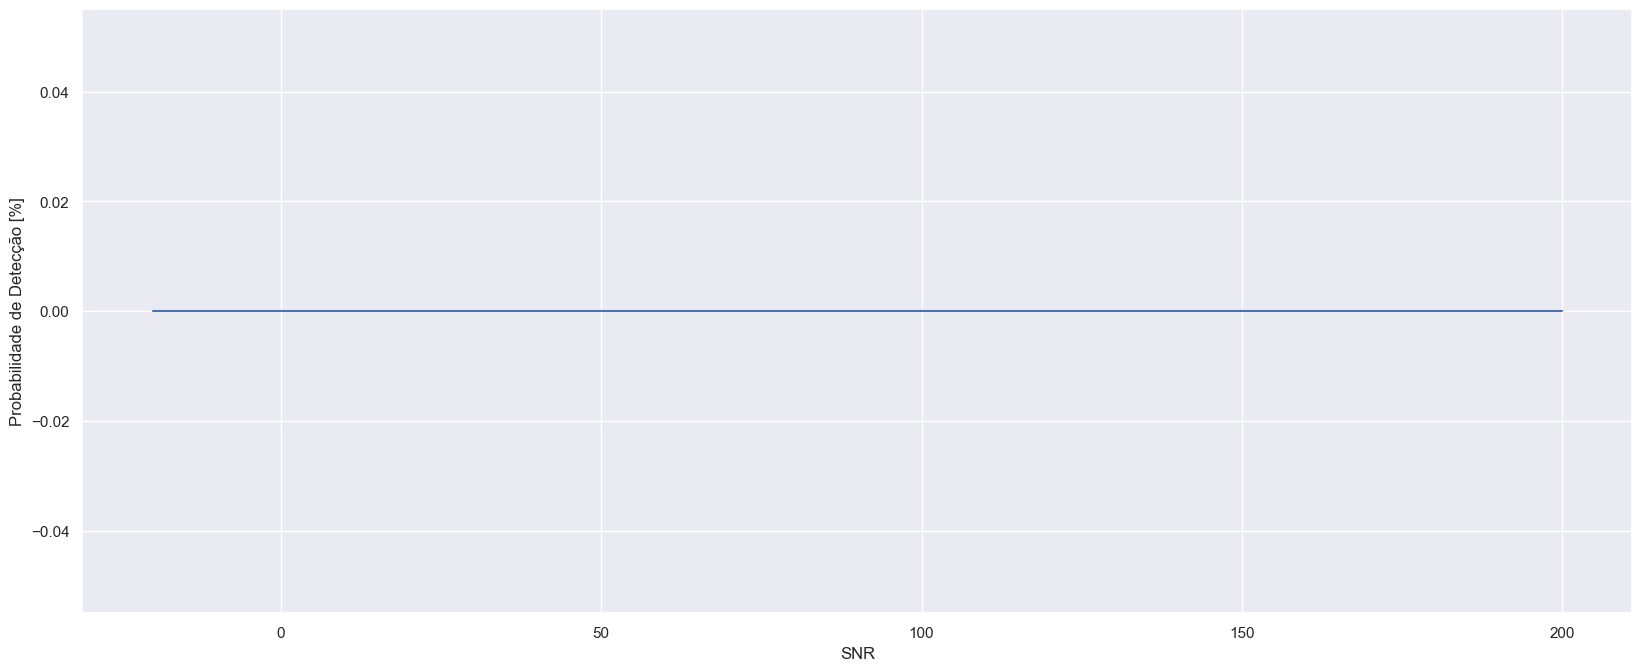

In [98]:
pD = pd.DataFrame({'SNR': listaSNRs,'Probabilidade de Detecção [%]':probDetec[:,0]})
sns.lineplot(data = pD,x='SNR',y='Probabilidade de Detecção [%]');

TypeError: object of type 'numpy.float64' has no len()

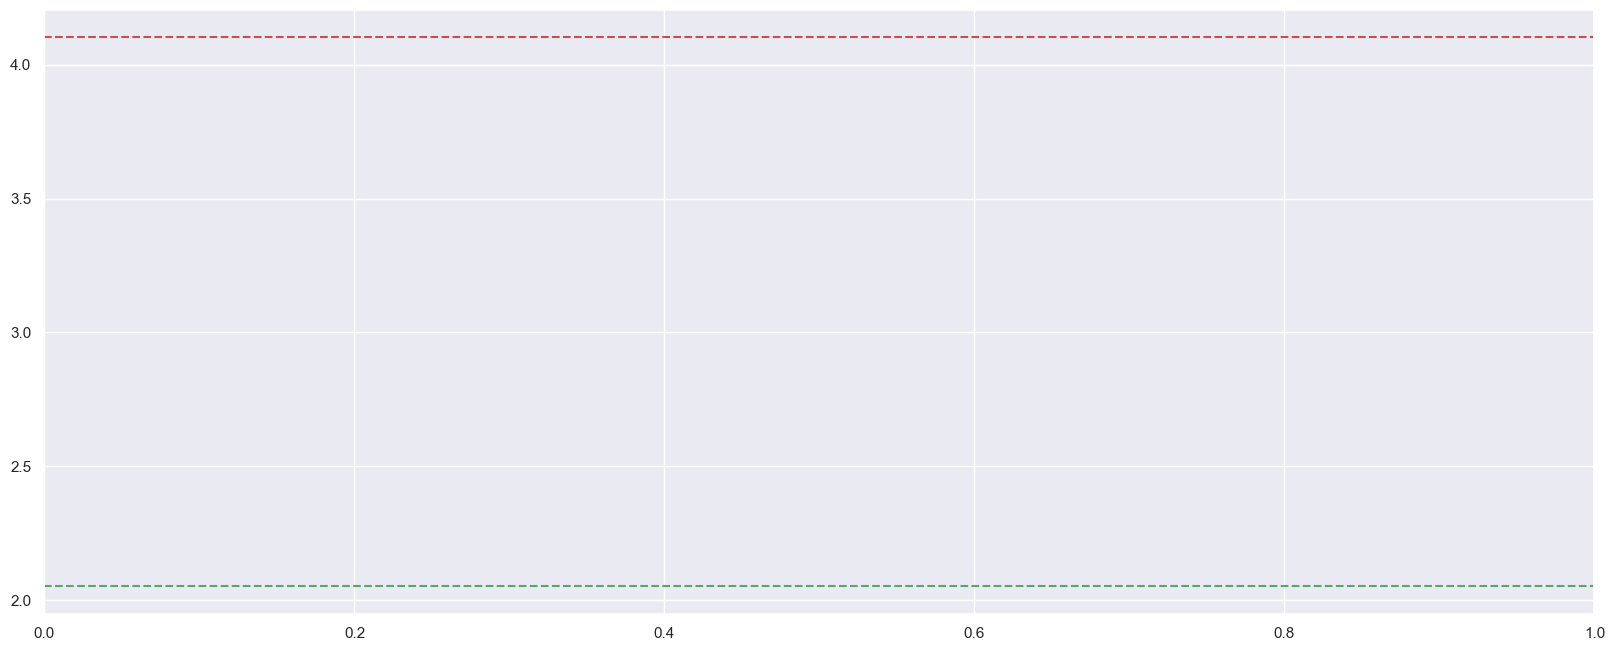

In [99]:
# f0 = 10
# fs = 100
# seno = np.sin(np.linspace(0,2*np.pi*fs/f0,num=N))
# # BIN = 
# S = abs(fft(seno))
# print(np.where(S==max(S))) # deu 10 = f0
# freq = fftfreq(seno.size, d=1/100)
# print(freq)
# sns.lineplot(data = np.sin(np.linspace(0,2*np.pi*fs/f0,num=N)))
plt.axhline(limiar, 0,1,c='r',linestyle='--')
plt.axhline(limiar/2, 0,1,c='g',linestyle='--')
sns.scatterplot(data = ORD)
plt.xticks(np.arange(0,100,1))
# print(ORD>BIN)
print(max(ORD))
print(limiar/2)
plt.title('MSC na melhor SNR')
plt.xlabel('Bins')
plt.ylabel('Valor da MSC')
# # print(nd)


Text(0.5, 1.0, 'Distribuição dos sinais em duas SNR')

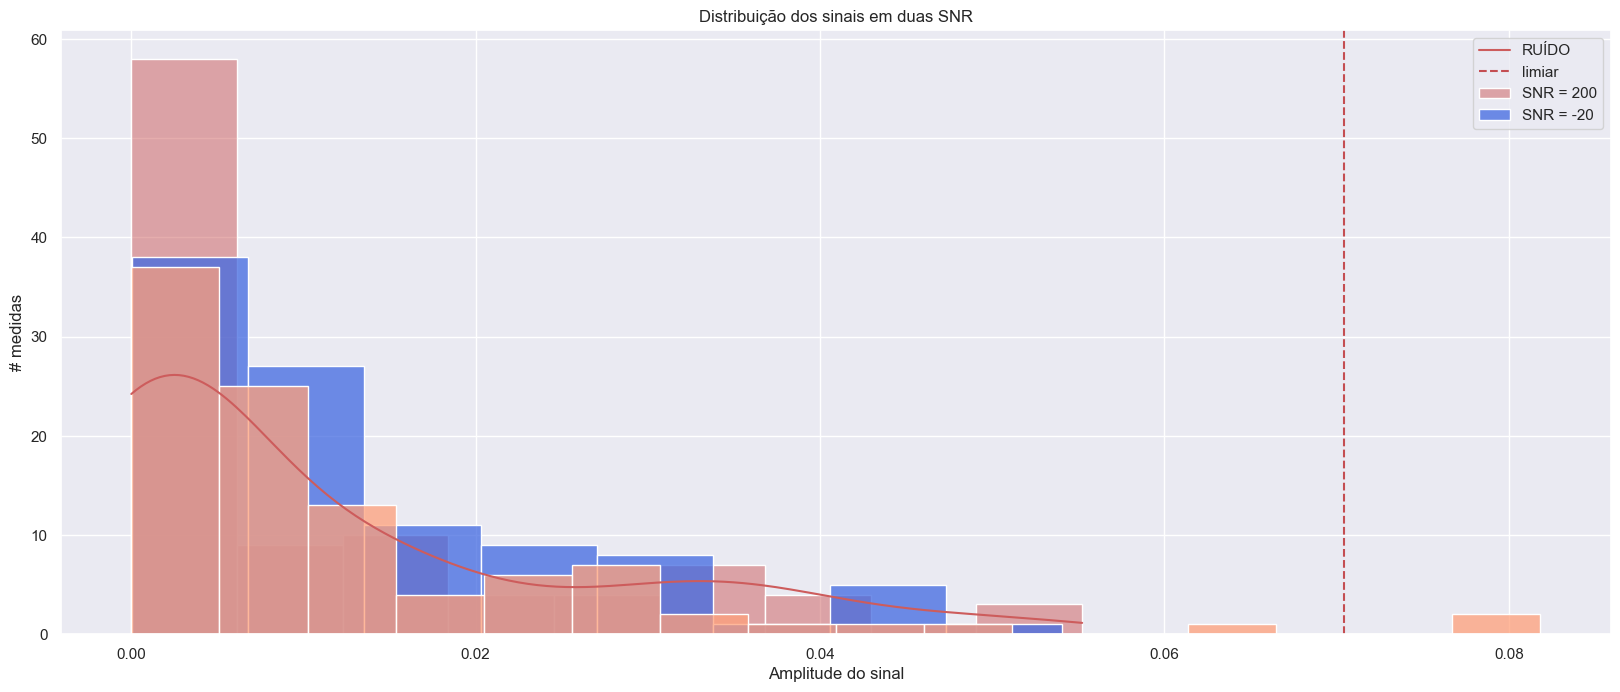

In [ ]:
# print(sinal.shape)
[_,B] = ord_MSC(sinal[-1,42,:],tamanhoJanela=tj,M=Mmax)
[_,A] = ord_MSC(sinal[0,42,:],tamanhoJanela=tj,M=Mmax)
[_,R] = ord_MSC(rd.randn(N,),tamanhoJanela=tj,M=Mmax)
# print(max(A))

sns.histplot(kde=True, data=R,color= 'indianred')
sns.histplot(kde= False,data = B, color='royalblue')
sns.histplot(kde=False, data = A, color='lightsalmon')
plt.axvline(limiar, 0,1,c='r',linestyle='--')
# plt.xlim([-5,len(A)/20])
texto = 'SNR = '+str(listaSNRs[-1])
plt.legend(['RUÍDO','limiar',texto, 'SNR = -20'])
plt.ylabel('# medidas')
plt.xlabel('Amplitude do sinal')
plt.title('Distribuição dos sinais em duas SNR')